## Pandas Implementation of a Fisher-transformed Rolling Pearson Correlation for PRx

Merck, Spring 2020

A Fisher-transformed rolling Pearson correlation is useful for computing the cerebral pressure reactivity index (PRx) from intracranial pressure (ICP) and mean arterial pressure (MAP) values.  PRx provides an index of patient cerebral pressure autoregulation after traumatic brain injury.

Steiner, Luzius A., Marek Czosnyka, Stefan K. Piechnik, Piotr Smielewski, Doris Chatfield, David K. Menon, and John D. Pickard. “Continuous Monitoring of Cerebrovascular Pressure Reactivity Allows Determination of Optimal Cerebral Perfusion Pressure in Patients with Traumatic Brain Injury.” Critical Care Medicine 30, no. 4 (April 2002): 733–38. https://doi.org/10.1097/00003246-200204000-00002.


Independent
          MAP        ICP       PRx
0   96.543333   9.647187       NaN
1  102.925227   9.794094       NaN
2   98.505121  10.843285       NaN
3  102.006356  11.373637       NaN
4   99.466381   7.530369  0.221142


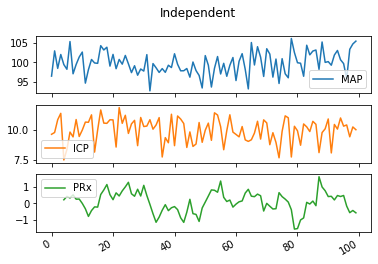

In [175]:
import numpy as np
import pandas as pd

def fisher_transformed_rolling_pearson(obs1, obs2, w_sz):

    # Format as a data frame with 2 columns
    df = pd.DataFrame(np.array([obs1, obs2]).T)
    
    # Compute correlation along moving window
    _rp = df.rolling(w_sz).corr().loc[:,0][:,1]
    
    # Compute the Fisher r->z transform
    _ftrp = np.arctanh(_rp)

    return _ftrp

def compute_prx(_map, icp, w_sz, title=None):
            
    prx = fisher_transformed_rolling_pearson(_map, icp, w_sz)
        
    df = pd.DataFrame({
        'MAP': _map,
        'ICP': icp,
        'PRx': prx
    })
        
    if title:
        print(title)
    print(df.head())    
    df.plot(subplots=True, title=title)

def get_correlated_obs(mean, cov, n_obs):
    return np.random.multivariate_normal(mean, cov, n_obs).T

n_obs = 100      # num obs
w_sz = 5         # window size
mean = [100,10]  # MAP is O(100), ICP is O(10)

# Independent Data

title = "Independent"
cov = [[10, 0], [0, 1]]

_map, icp = get_correlated_obs(mean, cov, n_obs)
compute_prx(_map, icp, w_sz, title)


Dependent
          MAP        ICP       PRx
0  100.755649   9.258744       NaN
1  102.995440  10.320187       NaN
2   99.797597   8.846991       NaN
3  102.710412  11.541116       NaN
4  100.747866   9.665606  1.330362


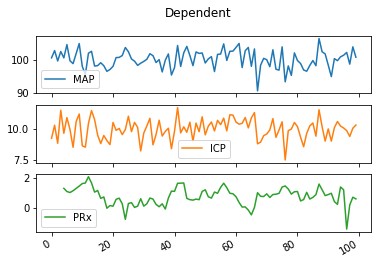

In [177]:
# Correlated Data

title = "Dependent"
cov = [[10, 2], [2, 1]]

_map, icp = get_correlated_obs(mean, cov, n_obs)
compute_prx(_map, icp, w_sz, title)


Anti-correlated
          MAP        ICP       PRx
0  100.210931   9.950981       NaN
1  100.597481  10.443137       NaN
2   98.569952   9.080318       NaN
3  100.027754  10.403692       NaN
4  104.100276   8.839973 -0.391207


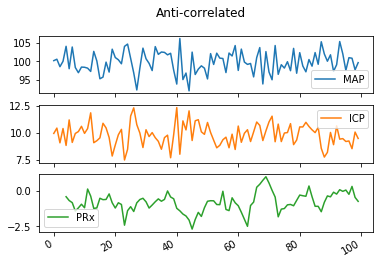

In [176]:
# Decorrelated Data

title = "Anti-correlated"
cov = [[10, -2], [-2, 1]]

_map, icp = get_correlated_obs(mean, cov, n_obs)
compute_prx(_map, icp, w_sz, title)
